<a href="https://colab.research.google.com/github/jakeoung/BayesianUnrolling/blob/master/BU3D_simple_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows a simple example of running BU3D.

The code works on both CPU and GPU mode. You can enable the CUDA in the menu: `Runtime > Change runtime type` and choose GPU in the hardware accelerator item.

In [1]:
%cd /content
!git clone https://github.com/jakeoung/BayesianUnrolling
%cd BayesianUnrolling/run
!pip install mat73

/content
Cloning into 'BayesianUnrolling'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 38 (delta 2), reused 4 (delta 1), pack-reused 22
Unpacking objects: 100% (38/38), done.
/content/BayesianUnrolling/run


In [2]:
import mat73
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import os
os.sys.path.append("../")

from unroll.model.vanilla import Model
from gen_initial import gen_initial_multiscale, shift_h

use_cuda = True if torch.cuda.is_available() else False
print(f"use_cuda: {use_cuda}")

print("")

use_cuda: True



In [3]:
## Load the histogram data with PPP=4, SBR=1
f = 'Reindeer_4.0_1.0.mat'    
fdict = mat73.loadmat(f)
tof = torch.FloatTensor(fdict["Y"])
tof = tof[0:-1:2, 0:-1:2, :] # choose half size

H, W, T = tof.shape
to_meter = T * 0.003 # depth scale factor from [0,1] -> the unit of meter

print(f"tof shape is {tof.shape}")

tof shape is torch.Size([277, 335, 1024])


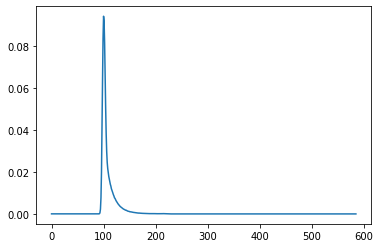

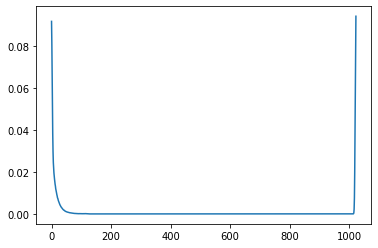

In [4]:
## Load and visualize the impulse response function
irf_ = scipy.io.loadmat("irf/irf_middlebury1024.mat")["irf"][0,:]
plt.plot(irf_); plt.show()
h1 = torch.FloatTensor(shift_h(irf_, T))

## Visualize the shifted IRF
plt.plot(h1); plt.show()

In [5]:
## Generate initial multiscale depths
L = 12
depths = gen_initial_multiscale(tof, h1, L, use_cuda=use_cuda)

4 scales completed. 8 additional scales are generated by separable 3d convolution.


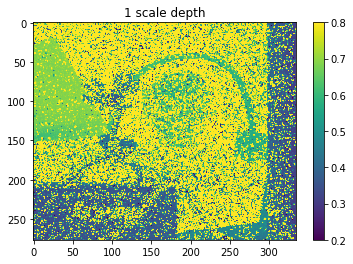

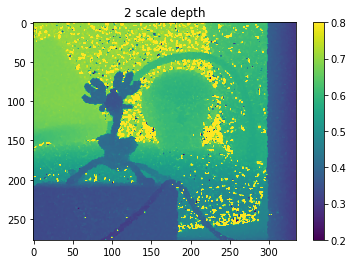

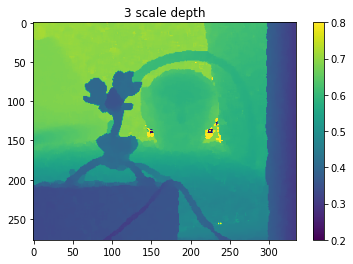

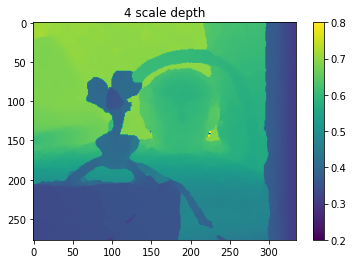

In [7]:
## Visualize the input initial multiscale depths
for i in range(4):
    plt.imshow(depths[i,:,:].cpu()*to_meter, vmin=0.2, vmax=0.8); plt.colorbar()
    plt.title(f"{i+1} scale depth"); plt.show() 

In [8]:
## Run the neural network
with torch.no_grad():
    model = Model(L)
    if use_cuda:
        model.cuda()
        model.load_state_dict(torch.load("model_baseline.pth"))
    else:
        model.load_state_dict(torch.load("model_baseline.pth", map_location=torch.device('cpu')))
    
    # to compute the uncertainty, turn on the debug option
    out = model(depths.unsqueeze(0), debug=True)

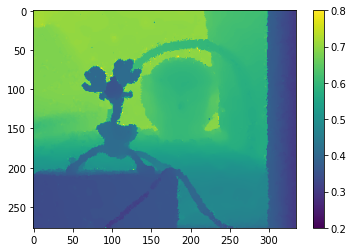

In [9]:
## Visualization of the results
depth_final = out[0][-1].cpu().numpy()

# # save the images for debugging
# depths = depths.cpu().numpy()

# if os.path.isdir("../fig/") == False:
#     os.makedirs("../fig/")

plt.imshow(depth_final[0,0,:,:]*to_meter); plt.clim(0.2, 0.8); plt.colorbar()

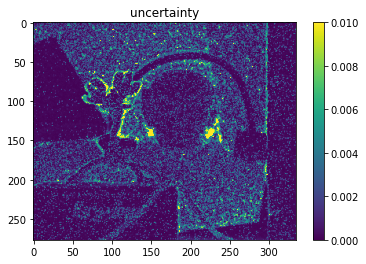

In [10]:
from compute_uncertainty import compute_uncertainty

eps = compute_uncertainty(out, to_meter=to_meter)
plt.imshow(eps, vmin=0, vmax=0.01)
plt.title("uncertainty")
plt.colorbar()
plt.show()